In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import GridSearchCV

**Description:**

- Target: Customers who purchase at least 2 times in last 30 month.

From this model, we can determine which customers that potentially purchase at least 2 times but in actual they not.

cut off validation = 90 days
cut off test = 30 days

In [2]:
df = pd.read_csv('cleaned_df.csv')

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109880 entries, 0 to 109879
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   order_id                  109880 non-null  object 
 1   customer_unique_id        109880 non-null  object 
 2   product_id                109880 non-null  object 
 3   seller_id                 109880 non-null  object 
 4   order_date                109880 non-null  object 
 5   price                     109880 non-null  float64
 6   freight_value             109880 non-null  float64
 7   customer_zip_code_prefix  109880 non-null  int64  
 8   customer_city             109880 non-null  object 
 9   customer_state            109880 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 8.4+ MB
None


,order_id,customer_unique_id,product_id,seller_id,order_date,price,freight_value,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-02 10:56:33,29.99,8.72,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-24 20:41:37,118.70,22.76,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-08 08:38:49,159.90,19.22,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-18 19:28:06,45.00,27.20,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-13 21:18:39,19.90,8.72,9195,santo andre,SP


In [3]:
mapper = {
    'order_date': 'first',
    'price': ['sum', 'mean'],
    'freight_value': ['sum', 'mean'],
    'customer_state': 'first'
}
df['order_date'] = pd.to_datetime(df['order_date']).dt.to_period('D')
unique_invoice = df.groupby(['order_id', 'customer_unique_id']).agg(mapper).reset_index()
unique_invoice.columns = pd.Index([f'{e[0]}_' + e[1] if (e[1] != '') and (e[1] != 'first') else e[0] for e in unique_invoice.columns.tolist()])

print(unique_invoice.info())
unique_invoice.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96211 entries, 0 to 96210
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype    
---  ------              --------------  -----    
 0   order_id            96211 non-null  object   
 1   customer_unique_id  96211 non-null  object   
 2   order_date          96211 non-null  period[D]
 3   price_sum           96211 non-null  float64  
 4   price_mean          96211 non-null  float64  
 5   freight_value_sum   96211 non-null  float64  
 6   freight_value_mean  96211 non-null  float64  
 7   customer_state      96211 non-null  object   
dtypes: float64(4), object(3), period[D](1)
memory usage: 5.9+ MB
None


,order_id,customer_unique_id,order_date,price_sum,price_mean,freight_value_sum,freight_value_mean,customer_state
0,00010242fe8c5a6d1ba2dd792cb16214,871766c5855e863f6eccc05f988b23cb,2017-09-13,58.90,58.90,13.29,13.29,RJ
1,00018f77f2f0320c557190d7a144bdd3,eb28e67c4c0b83846050ddfb8a35d051,2017-04-26,239.90,239.90,19.93,19.93,SP
2,000229ec398224ef6ca0657da4fc703e,3818d81c6709e39d06b2738a8d3a2474,2018-01-14,199.00,199.00,17.87,17.87,MG
3,00024acbcdf0a6daa1e931b038114c75,af861d436cfc08b2c2ddefd0ba074622,2018-08-08,12.99,12.99,12.79,12.79,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,64b576fb70d441e8f1b2d7d446e483c5,2017-02-04,199.90,199.90,18.14,18.14,SP


In [4]:
unique_invoice['time_diff'] = unique_invoice.groupby('customer_unique_id')['order_date'].diff()

unique_invoice['does_purchase_2_times'] = unique_invoice['time_diff'].apply(lambda x: 1 if x <= pd.Timedelta(days=30) else 0)
unique_invoice = unique_invoice.drop(['time_diff'], axis=1)

print(unique_invoice.info())
unique_invoice.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96211 entries, 0 to 96210
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype    
---  ------                 --------------  -----    
 0   order_id               96211 non-null  object   
 1   customer_unique_id     96211 non-null  object   
 2   order_date             96211 non-null  period[D]
 3   price_sum              96211 non-null  float64  
 4   price_mean             96211 non-null  float64  
 5   freight_value_sum      96211 non-null  float64  
 6   freight_value_mean     96211 non-null  float64  
 7   customer_state         96211 non-null  object   
 8   does_purchase_2_times  96211 non-null  int64    
dtypes: float64(4), int64(1), object(3), period[D](1)
memory usage: 6.6+ MB
None


,order_id,customer_unique_id,order_date,price_sum,price_mean,freight_value_sum,freight_value_mean,customer_state,does_purchase_2_times
0,00010242fe8c5a6d1ba2dd792cb16214,871766c5855e863f6eccc05f988b23cb,2017-09-13,58.90,58.90,13.29,13.29,RJ,0
1,00018f77f2f0320c557190d7a144bdd3,eb28e67c4c0b83846050ddfb8a35d051,2017-04-26,239.90,239.90,19.93,19.93,SP,0
2,000229ec398224ef6ca0657da4fc703e,3818d81c6709e39d06b2738a8d3a2474,2018-01-14,199.00,199.00,17.87,17.87,MG,0
3,00024acbcdf0a6daa1e931b038114c75,af861d436cfc08b2c2ddefd0ba074622,2018-08-08,12.99,12.99,12.79,12.79,SP,0
4,00042b26cf59d7ce69dfabb4e55b4fd9,64b576fb70d441e8f1b2d7d446e483c5,2017-02-04,199.90,199.90,18.14,18.14,SP,0


In [5]:
# Order reviews dataset
df_reviews = pd.read_csv('data/olist_order_reviews_dataset.csv')
print(df_reviews.info())

df_reviews.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB
None


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [6]:
df_reviews['review_creation_date'] = pd.to_datetime(df_reviews['review_creation_date'])
df_reviews['review_answer_timestamp'] = pd.to_datetime(df_reviews['review_answer_timestamp'])
df_reviews['diff_response'] = df_reviews['review_answer_timestamp'] - df_reviews['review_creation_date']
df_reviews['diff_response_hr'] = round(df_reviews['diff_response'].dt.total_seconds() / 3600, 0)

df_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,diff_response,diff_response_hr
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18,2018-01-18 21:46:59,0 days 21:46:59,22.0
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10,2018-03-11 03:05:13,1 days 03:05:13,27.0
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17,2018-02-18 14:36:24,1 days 14:36:24,39.0
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06,0 days 22:02:06,22.0
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53,1 days 10:26:53,34.0


In [7]:
df_reviews['review_score'].value_counts()

5    57328
4    19142
1    11424
3     8179
2     3151
Name: review_score, dtype: int64

In [8]:
mapper = {
    'review_score': 'mean',
    'diff_response_hr': 'mean'
}

reviews_groupby = df_reviews.groupby('order_id').agg(mapper).reset_index()

print(reviews_groupby.info())
reviews_groupby.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98673 entries, 0 to 98672
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_id          98673 non-null  object 
 1   review_score      98673 non-null  float64
 2   diff_response_hr  98673 non-null  float64
dtypes: float64(2), object(1)
memory usage: 2.3+ MB
None


,order_id,review_score,diff_response_hr
0,00010242fe8c5a6d1ba2dd792cb16214,5.0,35.0
1,00018f77f2f0320c557190d7a144bdd3,4.0,60.0
2,000229ec398224ef6ca0657da4fc703e,5.0,16.0
3,00024acbcdf0a6daa1e931b038114c75,4.0,17.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,5.0,35.0


In [9]:
# Order payments dataset
df_payments = pd.read_csv("data/olist_order_payments_dataset.csv")

print(df_payments.info())
df_payments.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB
None


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [10]:
def mode(x):
    return x.mode()[0]
mapper = {
    'payment_type': mode,
    'payment_value': ['mean', 'sum'],
    'payment_sequential': 'mean',
    'payment_installments': ['mean', 'sum']
}

payment_groupby = df_payments.groupby('order_id').agg(mapper).reset_index()
payment_groupby.columns = pd.Index([f'{e[0]}_' + e[1] if (e[1] != '') and (e[1] != 'first') else e[0] for e in payment_groupby.columns.tolist()])
print(payment_groupby.info())
payment_groupby.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99440 entries, 0 to 99439
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   order_id                   99440 non-null  object 
 1   payment_type_mode          99440 non-null  object 
 2   payment_value_mean         99440 non-null  float64
 3   payment_value_sum          99440 non-null  float64
 4   payment_sequential_mean    99440 non-null  float64
 5   payment_installments_mean  99440 non-null  float64
 6   payment_installments_sum   99440 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 5.3+ MB
None


,order_id,payment_type_mode,payment_value_mean,payment_value_sum,payment_sequential_mean,payment_installments_mean,payment_installments_sum
0,00010242fe8c5a6d1ba2dd792cb16214,credit_card,72.19,72.19,1.0,2.0,2
1,00018f77f2f0320c557190d7a144bdd3,credit_card,259.83,259.83,1.0,3.0,3
2,000229ec398224ef6ca0657da4fc703e,credit_card,216.87,216.87,1.0,5.0,5
3,00024acbcdf0a6daa1e931b038114c75,credit_card,25.78,25.78,1.0,2.0,2
4,00042b26cf59d7ce69dfabb4e55b4fd9,credit_card,218.04,218.04,1.0,3.0,3


In [48]:
dataset = pd.merge(unique_invoice, reviews_groupby, on='order_id', how='left')
dataset = pd.merge(dataset, payment_groupby, on='order_id', how='left')

print(dataset.info())
dataset.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96211 entries, 0 to 96210
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype    
---  ------                     --------------  -----    
 0   order_id                   96211 non-null  object   
 1   customer_unique_id         96211 non-null  object   
 2   order_date                 96211 non-null  period[D]
 3   price_sum                  96211 non-null  float64  
 4   price_mean                 96211 non-null  float64  
 5   freight_value_sum          96211 non-null  float64  
 6   freight_value_mean         96211 non-null  float64  
 7   customer_state             96211 non-null  object   
 8   does_purchase_2_times      96211 non-null  int64    
 9   review_score               95568 non-null  float64  
 10  diff_response_hr           95568 non-null  float64  
 11  payment_type_mode          96211 non-null  object   
 12  payment_value_mean         96211 non-null  float64  
 13  payment_value_su

,order_id,customer_unique_id,order_date,price_sum,price_mean,freight_value_sum,freight_value_mean,customer_state,does_purchase_2_times,review_score,diff_response_hr,payment_type_mode,payment_value_mean,payment_value_sum,payment_sequential_mean,payment_installments_mean,payment_installments_sum
0,00010242fe8c5a6d1ba2dd792cb16214,871766c5855e863f6eccc05f988b23cb,2017-09-13,58.90,58.90,13.29,13.29,RJ,0,5.0,35.0,credit_card,72.19,72.19,1.0,2.0,2
1,00018f77f2f0320c557190d7a144bdd3,eb28e67c4c0b83846050ddfb8a35d051,2017-04-26,239.90,239.90,19.93,19.93,SP,0,4.0,60.0,credit_card,259.83,259.83,1.0,3.0,3
2,000229ec398224ef6ca0657da4fc703e,3818d81c6709e39d06b2738a8d3a2474,2018-01-14,199.00,199.00,17.87,17.87,MG,0,5.0,16.0,credit_card,216.87,216.87,1.0,5.0,5
3,00024acbcdf0a6daa1e931b038114c75,af861d436cfc08b2c2ddefd0ba074622,2018-08-08,12.99,12.99,12.79,12.79,SP,0,4.0,17.0,credit_card,25.78,25.78,1.0,2.0,2
4,00042b26cf59d7ce69dfabb4e55b4fd9,64b576fb70d441e8f1b2d7d446e483c5,2017-02-04,199.90,199.90,18.14,18.14,SP,0,5.0,35.0,credit_card,218.04,218.04,1.0,3.0,3


In [49]:
dataset = dataset.fillna(0)

print(dataset.info())
dataset.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96211 entries, 0 to 96210
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype    
---  ------                     --------------  -----    
 0   order_id                   96211 non-null  object   
 1   customer_unique_id         96211 non-null  object   
 2   order_date                 96211 non-null  period[D]
 3   price_sum                  96211 non-null  float64  
 4   price_mean                 96211 non-null  float64  
 5   freight_value_sum          96211 non-null  float64  
 6   freight_value_mean         96211 non-null  float64  
 7   customer_state             96211 non-null  object   
 8   does_purchase_2_times      96211 non-null  int64    
 9   review_score               96211 non-null  float64  
 10  diff_response_hr           96211 non-null  float64  
 11  payment_type_mode          96211 non-null  object   
 12  payment_value_mean         96211 non-null  float64  
 13  payment_value_su

,order_id,customer_unique_id,order_date,price_sum,price_mean,freight_value_sum,freight_value_mean,customer_state,does_purchase_2_times,review_score,diff_response_hr,payment_type_mode,payment_value_mean,payment_value_sum,payment_sequential_mean,payment_installments_mean,payment_installments_sum
0,00010242fe8c5a6d1ba2dd792cb16214,871766c5855e863f6eccc05f988b23cb,2017-09-13,58.90,58.90,13.29,13.29,RJ,0,5.0,35.0,credit_card,72.19,72.19,1.0,2.0,2
1,00018f77f2f0320c557190d7a144bdd3,eb28e67c4c0b83846050ddfb8a35d051,2017-04-26,239.90,239.90,19.93,19.93,SP,0,4.0,60.0,credit_card,259.83,259.83,1.0,3.0,3
2,000229ec398224ef6ca0657da4fc703e,3818d81c6709e39d06b2738a8d3a2474,2018-01-14,199.00,199.00,17.87,17.87,MG,0,5.0,16.0,credit_card,216.87,216.87,1.0,5.0,5
3,00024acbcdf0a6daa1e931b038114c75,af861d436cfc08b2c2ddefd0ba074622,2018-08-08,12.99,12.99,12.79,12.79,SP,0,4.0,17.0,credit_card,25.78,25.78,1.0,2.0,2
4,00042b26cf59d7ce69dfabb4e55b4fd9,64b576fb70d441e8f1b2d7d446e483c5,2017-02-04,199.90,199.90,18.14,18.14,SP,0,5.0,35.0,credit_card,218.04,218.04,1.0,3.0,3


In [50]:
cohort_customer = dataset.groupby('customer_unique_id')\
                    .agg({'order_date': 'first'})\
                    .reset_index()\
                    .rename(columns={'order_date': 'first_purchase'})

dataset = pd.merge(dataset, cohort_customer, on='customer_unique_id', how='left')

print(dataset.info())
dataset.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96211 entries, 0 to 96210
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype    
---  ------                     --------------  -----    
 0   order_id                   96211 non-null  object   
 1   customer_unique_id         96211 non-null  object   
 2   order_date                 96211 non-null  period[D]
 3   price_sum                  96211 non-null  float64  
 4   price_mean                 96211 non-null  float64  
 5   freight_value_sum          96211 non-null  float64  
 6   freight_value_mean         96211 non-null  float64  
 7   customer_state             96211 non-null  object   
 8   does_purchase_2_times      96211 non-null  int64    
 9   review_score               96211 non-null  float64  
 10  diff_response_hr           96211 non-null  float64  
 11  payment_type_mode          96211 non-null  object   
 12  payment_value_mean         96211 non-null  float64  
 13  payment_value_su

,order_id,customer_unique_id,order_date,price_sum,price_mean,freight_value_sum,freight_value_mean,customer_state,does_purchase_2_times,review_score,diff_response_hr,payment_type_mode,payment_value_mean,payment_value_sum,payment_sequential_mean,payment_installments_mean,payment_installments_sum,first_purchase
0,00010242fe8c5a6d1ba2dd792cb16214,871766c5855e863f6eccc05f988b23cb,2017-09-13,58.90,58.90,13.29,13.29,RJ,0,5.0,35.0,credit_card,72.19,72.19,1.0,2.0,2,2017-09-13
1,00018f77f2f0320c557190d7a144bdd3,eb28e67c4c0b83846050ddfb8a35d051,2017-04-26,239.90,239.90,19.93,19.93,SP,0,4.0,60.0,credit_card,259.83,259.83,1.0,3.0,3,2017-04-26
2,000229ec398224ef6ca0657da4fc703e,3818d81c6709e39d06b2738a8d3a2474,2018-01-14,199.00,199.00,17.87,17.87,MG,0,5.0,16.0,credit_card,216.87,216.87,1.0,5.0,5,2018-01-14
3,00024acbcdf0a6daa1e931b038114c75,af861d436cfc08b2c2ddefd0ba074622,2018-08-08,12.99,12.99,12.79,12.79,SP,0,4.0,17.0,credit_card,25.78,25.78,1.0,2.0,2,2018-08-08
4,00042b26cf59d7ce69dfabb4e55b4fd9,64b576fb70d441e8f1b2d7d446e483c5,2017-02-04,199.90,199.90,18.14,18.14,SP,0,5.0,35.0,credit_card,218.04,218.04,1.0,3.0,3,2017-02-04


In [51]:
# Encoding category
from sklearn.preprocessing import OneHotEncoder

# encoder_state = OneHotEncoder(drop='first', sparse_output=False)
encoder_payment_type = OneHotEncoder(sparse_output=False)
# transform data
# onehot_state = encoder_state.fit_transform(dataset['customer_state'].values.reshape(-1, 1))
# column_state = encoder_state.get_feature_names_out(['customer_state'])

onehot_payment_type = encoder_payment_type.fit_transform(dataset['payment_type_mode'].values.reshape(-1, 1))
column_payment_type = encoder_payment_type.get_feature_names_out(['payment_type_mode'])

# print("Encoded data:\n", onehot)
# print("Column names:", column_names)

# encoded_state = pd.DataFrame(onehot_state, columns=column_state)
encoded_payment_type = pd.DataFrame(onehot_payment_type, columns=column_payment_type)

# dataset = pd.concat([dataset, encoded_state, encoded_payment_type], axis=1)
dataset = pd.concat([dataset, encoded_payment_type], axis=1)

print(dataset.info())
dataset.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96211 entries, 0 to 96210
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype    
---  ------                         --------------  -----    
 0   order_id                       96211 non-null  object   
 1   customer_unique_id             96211 non-null  object   
 2   order_date                     96211 non-null  period[D]
 3   price_sum                      96211 non-null  float64  
 4   price_mean                     96211 non-null  float64  
 5   freight_value_sum              96211 non-null  float64  
 6   freight_value_mean             96211 non-null  float64  
 7   customer_state                 96211 non-null  object   
 8   does_purchase_2_times          96211 non-null  int64    
 9   review_score                   96211 non-null  float64  
 10  diff_response_hr               96211 non-null  float64  
 11  payment_type_mode              96211 non-null  object   
 12  payment_value_mean

,order_id,customer_unique_id,order_date,price_sum,price_mean,freight_value_sum,freight_value_mean,customer_state,does_purchase_2_times,review_score,...,payment_value_mean,payment_value_sum,payment_sequential_mean,payment_installments_mean,payment_installments_sum,first_purchase,payment_type_mode_boleto,payment_type_mode_credit_card,payment_type_mode_debit_card,payment_type_mode_voucher
0,00010242fe8c5a6d1ba2dd792cb16214,871766c5855e863f6eccc05f988b23cb,2017-09-13,58.90,58.90,13.29,13.29,RJ,0,5.0,...,72.19,72.19,1.0,2.0,2,2017-09-13,0.0,1.0,0.0,0.0
1,00018f77f2f0320c557190d7a144bdd3,eb28e67c4c0b83846050ddfb8a35d051,2017-04-26,239.90,239.90,19.93,19.93,SP,0,4.0,...,259.83,259.83,1.0,3.0,3,2017-04-26,0.0,1.0,0.0,0.0
2,000229ec398224ef6ca0657da4fc703e,3818d81c6709e39d06b2738a8d3a2474,2018-01-14,199.00,199.00,17.87,17.87,MG,0,5.0,...,216.87,216.87,1.0,5.0,5,2018-01-14,0.0,1.0,0.0,0.0
3,00024acbcdf0a6daa1e931b038114c75,af861d436cfc08b2c2ddefd0ba074622,2018-08-08,12.99,12.99,12.79,12.79,SP,0,4.0,...,25.78,25.78,1.0,2.0,2,2018-08-08,0.0,1.0,0.0,0.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,64b576fb70d441e8f1b2d7d446e483c5,2017-02-04,199.90,199.90,18.14,18.14,SP,0,5.0,...,218.04,218.04,1.0,3.0,3,2017-02-04,0.0,1.0,0.0,0.0


In [52]:
# Time splitting 
n_days = 90
max_date = dataset['first_purchase'].max()
cutoff = max_date - pd.to_timedelta(n_days, unit='d')

temp_in = dataset[dataset['first_purchase'] <= cutoff]
temp_out = dataset[dataset['first_purchase'] > cutoff]

In [53]:
print("Test data:")
print(f'min:{temp_out["first_purchase"].min()} max: {temp_out["first_purchase"].max()}')
print("Train data:")
print(f'min:{temp_in["first_purchase"].min()} max: {temp_in["first_purchase"].max()}')

Test data:
min:2018-06-01 max: 2018-08-29
Train data:
min:2017-01-05 max: 2018-05-31


In [54]:
# Splitting test and validation
n_days = 30
max_date = temp_out['first_purchase'].max()
cutoff = max_date - pd.to_timedelta(n_days, unit='d')

temp_out_val = temp_out[temp_out['first_purchase'] <= cutoff]
temp_out_test = temp_out[temp_out['first_purchase'] > cutoff]

In [55]:
drop_columns = ['order_id', 'customer_unique_id', 'order_date', 'first_purchase', 'customer_state', 'payment_type_mode']

target = 'does_purchase_2_times'

# Train data
temp_in = temp_in.drop(drop_columns, axis=1)
y_train = temp_in[target]
X_train = temp_in.drop(target, axis=1)

# Validation data
temp_out_val = temp_out_val.drop(drop_columns, axis=1)
y_val = temp_out_val[target]
X_val = temp_out_val.drop(target, axis=1)

# Test data
temp_out_test = temp_out_test.drop(drop_columns, axis=1)
y_test = temp_out_test[target]
X_test = temp_out_test.drop(target, axis=1)

In [56]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train, y_train= smote.fit_resample(X_train, y_train)
# X_val, y_val= smote.fit_resample(X_val, y_val)

In [57]:
X_train

,price_sum,price_mean,freight_value_sum,freight_value_mean,review_score,diff_response_hr,payment_value_mean,payment_value_sum,payment_sequential_mean,payment_installments_mean,payment_installments_sum,payment_type_mode_boleto,payment_type_mode_credit_card,payment_type_mode_debit_card,payment_type_mode_voucher
0,58.900000,58.900000,13.290000,13.290000,5.000000,35.000000,72.190000,72.190000,1.000000,2.000000,2,0.000000,1.000000,0.0,0.0
1,239.900000,239.900000,19.930000,19.930000,4.000000,60.000000,259.830000,259.830000,1.000000,3.000000,3,0.000000,1.000000,0.0,0.0
2,199.000000,199.000000,17.870000,17.870000,5.000000,16.000000,216.870000,216.870000,1.000000,5.000000,5,0.000000,1.000000,0.0,0.0
3,199.900000,199.900000,18.140000,18.140000,5.000000,35.000000,218.040000,218.040000,1.000000,3.000000,3,0.000000,1.000000,0.0,0.0
4,21.900000,21.900000,12.690000,12.690000,4.000000,43.000000,34.590000,34.590000,1.000000,1.000000,1,1.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151441,212.432222,212.432222,19.995911,19.995911,5.000000,99.881481,232.428133,232.428133,1.000000,3.000000,3,0.000000,1.000000,0.0,0.0
151442,30.932418,30.932418,15.704205,15.704205,5.000000,43.154902,17.373217,46.636623,1.880283,1.507044,4,0.000000,0.000000,0.0,1.0
151443,184.489384,184.489384,26.372011,26.372011,4.454025,98.281582,210.861395,210.861395,1.000000,7.729877,7,0.000000,1.000000,0.0,0.0
151444,152.248896,38.062224,59.863478,14.965870,5.000000,42.009498,212.112375,212.112375,1.000000,5.834916,5,0.000000,1.000000,0.0,0.0


In [58]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_val, y_val= smote.fit_resample(X_val, y_val)


In [59]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the training data
train_columns = X_train.columns
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=train_columns)

# Transform the test data
val_columns = X_val.columns
X_val = scaler.transform(X_val)
X_val = pd.DataFrame(X_val, columns=val_columns)

# Transform the test data
test_columns = X_test.columns
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=test_columns)

In [60]:
X_train

,price_sum,price_mean,freight_value_sum,freight_value_mean,review_score,diff_response_hr,payment_value_mean,payment_value_sum,payment_sequential_mean,payment_installments_mean,payment_installments_sum,payment_type_mode_boleto,payment_type_mode_credit_card,payment_type_mode_debit_card,payment_type_mode_voucher
0,-0.378020,-0.336975,-0.438382,-0.431824,0.713112,-0.172593,-0.396256,-0.403760,-0.113180,-0.410221,-0.372057,-0.554785,0.607809,-0.100064,-0.165307
1,0.592365,0.747900,-0.109656,0.067882,-0.111839,-0.059164,0.564375,0.550606,-0.113180,-0.028443,0.011047,-0.554785,0.607809,-0.100064,-0.165307
2,0.373090,0.502754,-0.211640,-0.087147,0.713112,-0.258799,0.344439,0.332105,-0.113180,0.735113,0.777254,-0.554785,0.607809,-0.100064,-0.165307
3,0.377915,0.508149,-0.198273,-0.066828,0.713112,-0.172593,0.350429,0.338056,-0.113180,-0.028443,0.011047,-0.554785,0.607809,-0.100064,-0.165307
4,-0.576386,-0.558745,-0.468087,-0.476978,-0.111839,-0.136296,-0.588751,-0.594999,-0.113180,-0.791999,-0.755160,2.132353,-1.945687,-0.100064,-0.165307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151441,0.445104,0.583264,-0.106393,0.072843,0.713112,0.121784,0.424090,0.411236,-0.113180,-0.028443,0.011047,-0.554785,0.607809,-0.100064,-0.165307
151442,-0.527961,-0.504607,-0.318862,-0.250138,0.713112,-0.135593,-0.676893,-0.533728,4.292416,-0.598421,0.394150,-0.554785,-1.945687,-0.100064,7.049583
151443,0.295295,0.415781,0.209269,0.552689,0.262709,0.114525,0.313678,0.301544,-0.113180,1.777321,1.543461,-0.554785,0.607809,-0.100064,-0.165307
151444,0.122446,-0.461872,1.867331,-0.305703,0.713112,-0.140790,0.320082,0.307907,-0.113180,1.053866,0.777254,-0.554785,0.607809,-0.100064,-0.165307


In [61]:
y_train.value_counts()

0    75723
1    75723
Name: does_purchase_2_times, dtype: int64

In [62]:
y_val.value_counts()

0    11684
1    11684
Name: does_purchase_2_times, dtype: int64

In [63]:
xgb_clf = XGBClassifier(objective='binary:logistic', random_state=123)

xgb_clf_model = GridSearchCV(estimator=xgb_clf, 
                             param_grid=dict(learning_rate=[0.01, 0.1, 0.3, 0.5]),
                             scoring='roc_auc',
                             refit=True,
                             cv=5)


xgb_clf_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=123, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.3, 0.5]},
             scoring='roc_auc')

In [64]:
print("Best score: ", xgb_clf_model.best_score_)
print("Best params: ", xgb_clf_model.best_params_)
print("Best estimator: \n", xgb_clf_model.best_estimator_)

# Prediction probability
y_pred_prob_train = xgb_clf_model.predict_proba(X_train)
y_pred_prob_val = xgb_clf_model.predict_proba(X_val)

# Set threshold
threshold = 0.2

# Convert probabilities to class labels
y_pred_val = np.where(y_pred_prob_val[:, 1] > threshold, 1, 0)

Best score:  0.9910147143631611
Best params:  {'learning_rate': 0.5}
Best estimator: 
 XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, ...)


In [65]:
# Model evaluation

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_val, y_pred_val)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9489


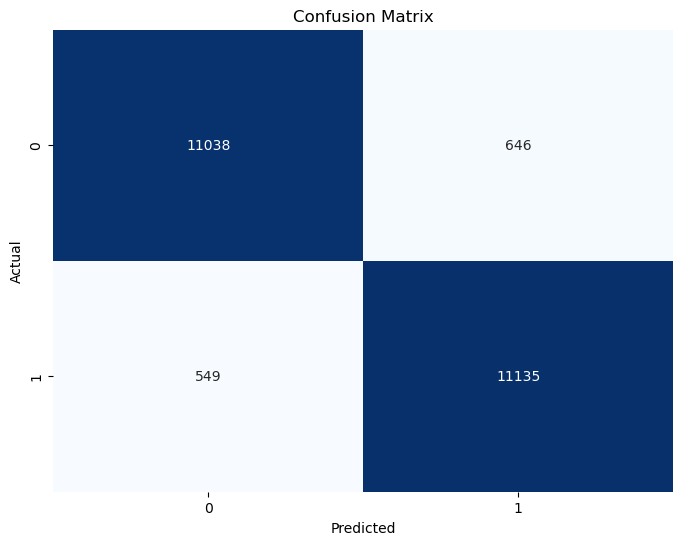

In [66]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
cm = confusion_matrix(y_val, y_pred_val)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [67]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(y_val, y_pred_val))


              precision    recall  f1-score   support

           0       0.95      0.94      0.95     11684
           1       0.95      0.95      0.95     11684

    accuracy                           0.95     23368
   macro avg       0.95      0.95      0.95     23368
weighted avg       0.95      0.95      0.95     23368



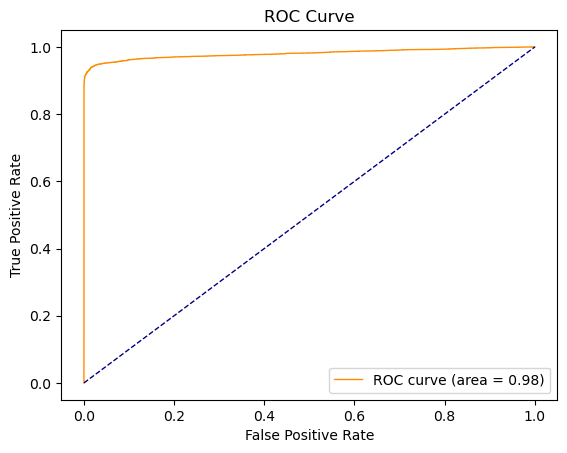

In [68]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob_val[:, 1])

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [69]:
feature_importances = xgb_clf_model \
                        .best_estimator_ \
                        .get_booster() \
                        .get_score(importance_type = 'gain') 

In [70]:
features = pd.DataFrame([feature_importances]).transpose().reset_index()
features.columns = ['Feature', 'Value']
features.sort_values(by='Value', ascending=False)

,Feature,Value
12,payment_type_mode_credit_card,731.670715
4,review_score,252.275406
10,payment_installments_sum,250.023697
9,payment_installments_mean,145.582214
11,payment_type_mode_boleto,120.456879
13,payment_type_mode_debit_card,31.082703
14,payment_type_mode_voucher,26.658587
5,diff_response_hr,23.840807
7,payment_value_sum,16.900990
0,price_sum,13.456591


In [72]:
# # Save Predictions
# predictions_df = pd.concat(
#     [
#         pd.DataFrame(predictions_clf)[[1]].set_axis(['pred_prob'], axis=1),
#         X
#     ], 
#     axis=1
# )

# predictions_df

In [73]:
# Apply to the last 30 days

# Prediction probability
y_pred_prob_test = xgb_clf_model.predict_proba(X_test)

# Set threshold
threshold = 0.5

# Convert probabilities to class labels
y_pred_test = np.where(y_pred_prob_test[:, 1] > threshold, 1, 0)

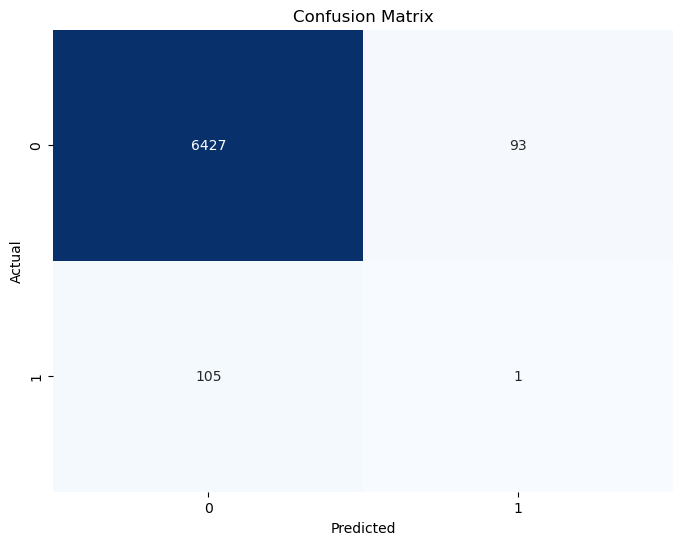

In [74]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


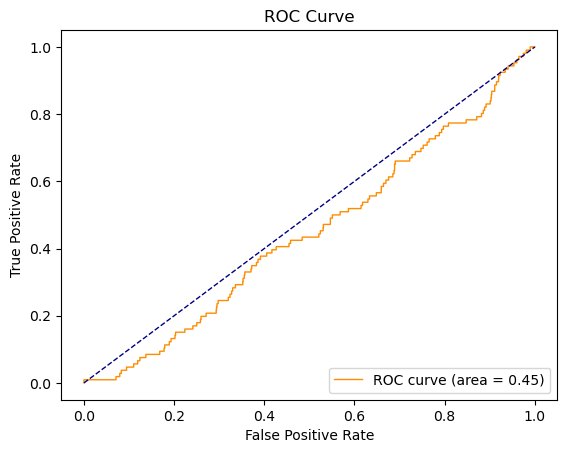

In [75]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_test[:, 1])

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [77]:
# Predict on test data
y_pred_val = rf_model.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred_val)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8840


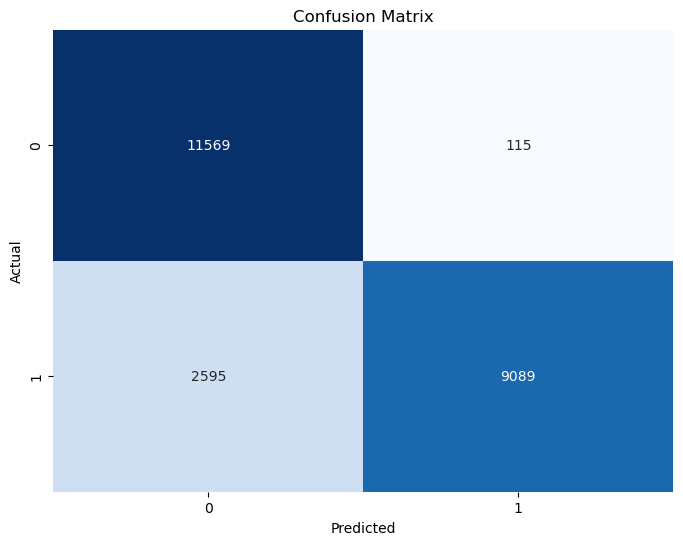

In [78]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
cm = confusion_matrix(y_val, y_pred_val)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [79]:
# Apply to the last 30 days

# Prediction probability
y_pred_prob_test = rf_model.predict_proba(X_test)

# Set threshold
threshold = 0.5

# Convert probabilities to class labels
y_pred_test = np.where(y_pred_prob_test[:, 1] > threshold, 1, 0)

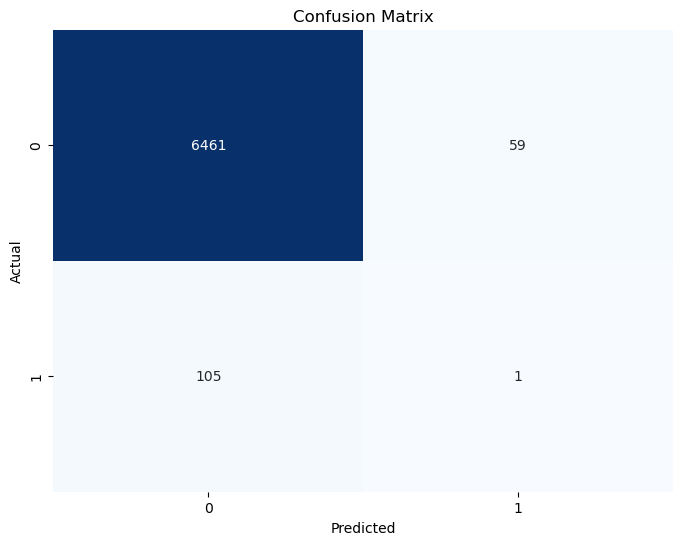

In [80]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
